# Q2

In [2]:
import requests
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

### Step 1

Download the hourly price data (i.e. Candlestick data) of BTCUSDT linear perpetual swaps from Binance since 2021 Jan till the latest data source you can get. Clean the data.

In [ ]:
def get_binance_data(symbol, interval, start_time, end_time):
    base_url = "https://fapi.binance.com/fapi/v1/klines"
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'endTime': end_time,
        'limit': 1000
    }
    
    data = []
    while True:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        klines = response.json()
        if not klines:
            break
        data.extend(klines)
        if len(klines) < 1000:
            break
        params['startTime'] = klines[-1][0] + 1
    
    df = pd.DataFrame(data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume', 
        'close_time', 'quote_asset_volume', 'number_of_trades', 
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df.astype({
        'open': 'float',
        'high': 'float',
        'low': 'float',
        'close': 'float',
        'volume': 'float',
        'quote_asset_volume': 'float',
        'number_of_trades': 'int',
        'taker_buy_base_asset_volume': 'float',
        'taker_buy_quote_asset_volume': 'float'
    })
    
    return df

start_time = int(datetime(2021, 1, 1).timestamp() * 1000)
end_time = int(datetime.now().timestamp() * 1000)

binance_data = get_binance_data('BTCUSDT', '1h', start_time, end_time)

In [6]:
binance_data = binance_data[['open','high','low','close','volume']]
binance_data

,open,high,low,close,volume
timestamp,,,,,
2020-12-31 16:00:00,28792.58,28837.77,28327.78,28408.72,13071.080
2020-12-31 17:00:00,28407.73,28750.00,28378.10,28603.10,9192.806
2020-12-31 18:00:00,28601.52,28923.71,28501.00,28883.17,8127.876
2020-12-31 19:00:00,28883.17,29037.09,28761.52,28917.08,8298.073
2020-12-31 20:00:00,28917.08,29180.99,28888.00,29155.97,5985.123
...,...,...,...,...,...
2024-08-06 10:00:00,55185.00,55422.90,54854.20,55039.90,12010.276
2024-08-06 11:00:00,55039.90,55377.00,54840.70,55188.00,11408.424
2024-08-06 12:00:00,55188.00,55443.20,54659.20,54752.60,16058.317


### Step 2

Create & define columns (alphas) by following the below formulas.

Remark: Please handle some marginal cases when denominator equals 0, can just assuming an insignificant value to the formula, for example on 'alpha_C', define denominator as max(high - low, 0.0001)

In [7]:
# alpha_a
Cumulative_Typical_Price = (binance_data['close'] + binance_data['high'] + binance_data['low']) / 3
Cumulative_Volume = binance_data['volume'].rolling(24).sum()
VWAP = (Cumulative_Typical_Price * binance_data['volume']).rolling(24).sum() / Cumulative_Volume
alpha_A = np.sqrt(binance_data['high'] * binance_data['low']) - VWAP
alpha_A

timestamp
2020-12-31 16:00:00            NaN
2020-12-31 17:00:00            NaN
2020-12-31 18:00:00            NaN
2020-12-31 19:00:00            NaN
2020-12-31 20:00:00            NaN
                          ...     
2024-08-06 10:00:00    1686.532381
2024-08-06 11:00:00    1479.556428
2024-08-06 12:00:00    1026.808512
2024-08-06 13:00:00     332.309821
2024-08-06 14:00:00    1041.794047
Length: 31535, dtype: float64

In [8]:
# alpha_b
alpha_B = -1 * ((binance_data['low'] - binance_data['close']) * (binance_data['open'] ** 5)) / ((binance_data['low'] - binance_data['high']).replace(0,0.0001) * (binance_data['close'] ** 5))
alpha_B

timestamp
2020-12-31 16:00:00   -0.169725
2020-12-31 17:00:00   -0.584620
2020-12-31 18:00:00   -0.860866
2020-12-31 19:00:00   -0.561201
2020-12-31 20:00:00   -0.877744
                         ...   
2024-08-06 10:00:00   -0.330861
2024-08-06 11:00:00   -0.638943
2024-08-06 12:00:00   -0.123945
2024-08-06 13:00:00   -0.762597
2024-08-06 14:00:00   -0.680548
Length: 31535, dtype: float64

In [9]:
# alpha_c
alpha_C = ((binance_data['close'] - binance_data['open']) / (binance_data['high'] - binance_data['low']).replace(0,0.0001)) + 0.001
alpha_C

timestamp
2020-12-31 16:00:00   -0.751681
2020-12-31 17:00:00    0.526329
2020-12-31 18:00:00    0.667296
2020-12-31 19:00:00    0.124054
2020-12-31 20:00:00    0.816352
                         ...   
2024-08-06 10:00:00   -0.254143
2024-08-06 11:00:00    0.277151
2024-08-06 12:00:00   -0.554357
2024-08-06 13:00:00    0.380932
2024-08-06 14:00:00    0.705533
Length: 31535, dtype: float64

In [16]:
binance_data['alpha_A'] = alpha_A
binance_data['alpha_B'] = alpha_B
binance_data['alpha_C'] = alpha_C
binance_data = binance_data.dropna(subset=['alpha_A'])
binance_data

C:\Users\calin\AppData\Local\Temp\ipykernel_22672\42586023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binance_data['alpha_A'] = alpha_A
C:\Users\calin\AppData\Local\Temp\ipykernel_22672\42586023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binance_data['alpha_B'] = alpha_B
C:\Users\calin\AppData\Local\Temp\ipykernel_22672\42586023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

,open,high,low,close,volume,alpha_A,alpha_B,alpha_C
timestamp,,,,,,,,
2021-01-01 15:00:00,29354.57,29411.93,29043.75,29210.84,11230.179,107.857402,-0.465102,-0.389380
2021-01-01 16:00:00,29210.85,29388.10,29152.20,29324.21,6357.585,107.494796,-0.715180,0.481543
2021-01-01 17:00:00,29324.21,29368.53,28927.35,29099.00,10867.198,-39.653866,-0.404361,-0.509472
2021-01-01 18:00:00,29099.00,29300.00,28627.12,29086.62,20168.624,-223.871359,-0.684340,-0.017399
2021-01-01 19:00:00,29086.62,29150.00,28967.17,29048.47,6274.763,-133.975316,-0.447603,-0.207664
...,...,...,...,...,...,...,...,...
2024-08-06 10:00:00,55185.00,55422.90,54854.20,55039.90,12010.276,1686.532381,-0.330861,-0.254143
2024-08-06 11:00:00,55039.90,55377.00,54840.70,55188.00,11408.424,1479.556428,-0.638943,0.277151
2024-08-06 12:00:00,55188.00,55443.20,54659.20,54752.60,16058.317,1026.808512,-0.123945,-0.554357


### Step 3

After computing the 3 'alphas', you can design any approaches for on these 'alphas' (can be of different approaches on each 'alphas' or same approach on different 'alphas', can simple as if alpha_X is bigger than zero, long; vice versa, or do another layer of data transformation to signal). You can combine the performance of strategies built on different alphas. Compute the backtest result
(sharpe ratio, return/CAGR, maximum drawdown, calmar ratio, with a plot of performance curve).

Just use the strategy in the text: **If alpha_X is bigger than zero, long; vice versa**

In [30]:
def strategy(alpha):
    return np.where(alpha > 0, 1, -1)

binance_data_copy = binance_data.copy()
binance_data_copy['strategy_A'] = strategy(binance_data_copy['alpha_A'])
binance_data_copy['strategy_B'] = strategy(binance_data_copy['alpha_B'])
binance_data_copy['strategy_C'] = strategy(binance_data_copy['alpha_C'])
binance_data_copy

,open,high,low,close,volume,alpha_A,alpha_B,alpha_C,strategy_A,strategy_B,strategy_C
timestamp,,,,,,,,,,,
2021-01-01 15:00:00,29354.57,29411.93,29043.75,29210.84,11230.179,107.857402,-0.465102,-0.389380,1,-1,-1
2021-01-01 16:00:00,29210.85,29388.10,29152.20,29324.21,6357.585,107.494796,-0.715180,0.481543,1,-1,1
2021-01-01 17:00:00,29324.21,29368.53,28927.35,29099.00,10867.198,-39.653866,-0.404361,-0.509472,-1,-1,-1
2021-01-01 18:00:00,29099.00,29300.00,28627.12,29086.62,20168.624,-223.871359,-0.684340,-0.017399,-1,-1,-1
2021-01-01 19:00:00,29086.62,29150.00,28967.17,29048.47,6274.763,-133.975316,-0.447603,-0.207664,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-06 10:00:00,55185.00,55422.90,54854.20,55039.90,12010.276,1686.532381,-0.330861,-0.254143,1,-1,-1
2024-08-06 11:00:00,55039.90,55377.00,54840.70,55188.00,11408.424,1479.556428,-0.638943,0.277151,1,-1,1
2024-08-06 12:00:00,55188.00,55443.20,54659.20,54752.60,16058.317,1026.808512,-0.123945,-0.554357,1,-1,-1


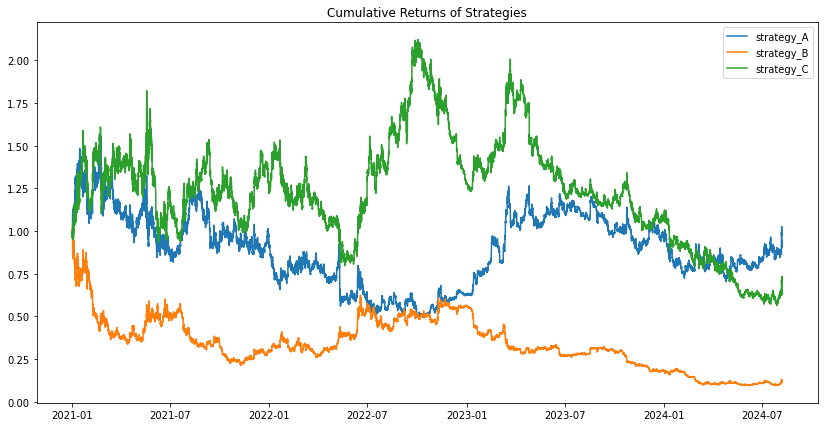

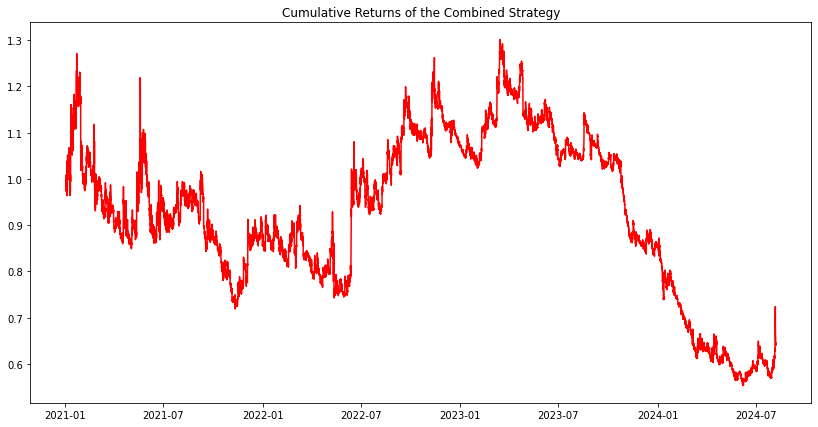

Performance metrics for strategy_A:
Sharpe Ratio: 0.30
CAGR: -1.75%
Max Drawdown: -68.37%
Calmar Ratio: -0.03

Performance metrics for strategy_B:
Sharpe Ratio: -0.60
CAGR: -45.11%
Max Drawdown: -90.56%
Calmar Ratio: -0.50

Performance metrics for strategy_C:
Sharpe Ratio: 0.13
CAGR: -11.72%
Max Drawdown: -73.40%
Calmar Ratio: -0.16

Performance metrics for combined_strategy:
Sharpe Ratio: -0.09
CAGR: -11.52%
Max Drawdown: -57.51%
Calmar Ratio: -0.20



In [33]:
# Backtest strategies
def backtest(data, strategy_col):
    data['returns'] = data['close'].pct_change()
    data[f'{strategy_col}_returns'] = data['returns'] * data[strategy_col].shift()
    data[f'{strategy_col}_cumulative_returns'] = (1 + data[f'{strategy_col}_returns']).cumprod()
    return data

# Backtest each strategy
for col in ['strategy_A', 'strategy_B', 'strategy_C']:
    binance_data_copy = backtest(binance_data_copy, col)

binance_data_copy['combined_strategy_returns'] = binance_data_copy[['strategy_A_returns', 'strategy_B_returns', 'strategy_C_returns']].mean(axis=1)
binance_data_copy['combined_strategy_cumulative_returns'] = (1 + binance_data_copy['combined_strategy_returns']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(binance_data_copy['strategy_A_cumulative_returns'],label = "strategy_A")
plt.plot(binance_data_copy['strategy_B_cumulative_returns'],label = "strategy_B")
plt.plot(binance_data_copy['strategy_C_cumulative_returns'],label = "strategy_C")
plt.legend()
plt.title('Cumulative Returns of Strategies')

# Plot combined cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(binance_data_copy['combined_strategy_cumulative_returns'],color = 'red')
plt.title('Cumulative Returns of the Combined Strategy')
plt.show()

# Compute performance metrics
def metrics(data, strategy_col):
    returns = data[f'{strategy_col}_returns']
    sharpe_ratio = np.sqrt(24 * 365) * (returns.mean() / returns.std())
    cagr = (data[f'{strategy_col}_cumulative_returns'][-1] ** (365*24 / len(data)) - 1) * 100
    max_drawdown = (data[f'{strategy_col}_cumulative_returns'] / data[f'{strategy_col}_cumulative_returns'].cummax() - 1).min() * 100
    calmar_ratio = cagr / abs(max_drawdown)
    return sharpe_ratio, cagr, max_drawdown, calmar_ratio

# Print performance metrics for each strategy
for col in ['strategy_A', 'strategy_B', 'strategy_C','combined_strategy']:
    sharpe_ratio, cagr, max_drawdown, calmar_ratio = metrics(binance_data_copy, col)
    print(f"Performance metrics for {col}:")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"CAGR: {cagr:.2f}%")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Calmar Ratio: {calmar_ratio:.2f}")
    print()

It can be found that the `sharpe ratio` of `strategy_B` is negative, so we change the strategy: **If alpha_B is bigger than zero, short; vice versa**

In [35]:
def strategy_B(alpha):
    return np.where(alpha > 0, -1, 1)

binance_data_copy = binance_data.copy()
binance_data_copy['strategy_A'] = strategy(binance_data_copy['alpha_A'])
binance_data_copy['strategy_B'] = strategy_B(binance_data_copy['alpha_B'])
binance_data_copy['strategy_C'] = strategy(binance_data_copy['alpha_C'])
binance_data_copy

,open,high,low,close,volume,alpha_A,alpha_B,alpha_C,strategy_A,strategy_B,strategy_C
timestamp,,,,,,,,,,,
2021-01-01 15:00:00,29354.57,29411.93,29043.75,29210.84,11230.179,107.857402,-0.465102,-0.389380,1,1,-1
2021-01-01 16:00:00,29210.85,29388.10,29152.20,29324.21,6357.585,107.494796,-0.715180,0.481543,1,1,1
2021-01-01 17:00:00,29324.21,29368.53,28927.35,29099.00,10867.198,-39.653866,-0.404361,-0.509472,-1,1,-1
2021-01-01 18:00:00,29099.00,29300.00,28627.12,29086.62,20168.624,-223.871359,-0.684340,-0.017399,-1,1,-1
2021-01-01 19:00:00,29086.62,29150.00,28967.17,29048.47,6274.763,-133.975316,-0.447603,-0.207664,-1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-06 10:00:00,55185.00,55422.90,54854.20,55039.90,12010.276,1686.532381,-0.330861,-0.254143,1,1,-1
2024-08-06 11:00:00,55039.90,55377.00,54840.70,55188.00,11408.424,1479.556428,-0.638943,0.277151,1,1,1
2024-08-06 12:00:00,55188.00,55443.20,54659.20,54752.60,16058.317,1026.808512,-0.123945,-0.554357,1,1,-1


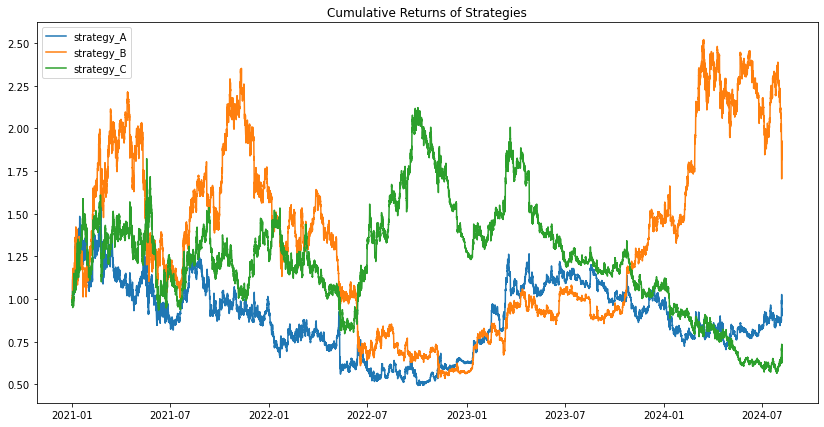

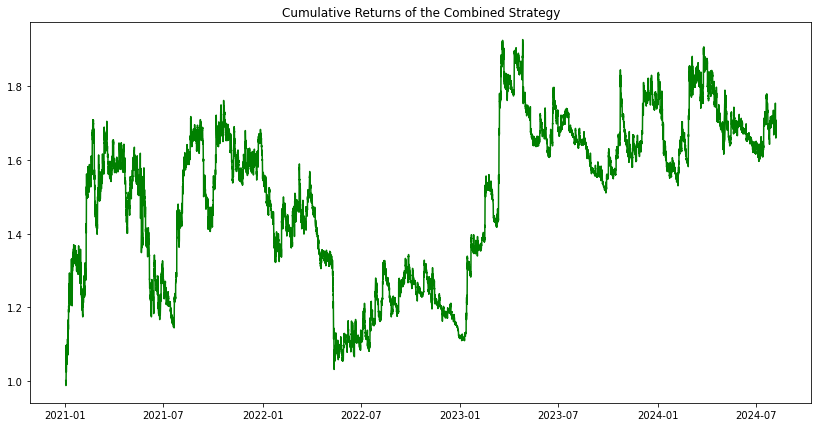

Performance metrics for strategy_A:
Sharpe Ratio: 0.30
CAGR: -1.75%
Max Drawdown: -68.37%
Calmar Ratio: -0.03

Performance metrics for strategy_B:
Sharpe Ratio: 0.60
CAGR: 19.97%
Max Drawdown: -77.24%
Calmar Ratio: 0.26

Performance metrics for strategy_C:
Sharpe Ratio: 0.13
CAGR: -11.72%
Max Drawdown: -73.40%
Calmar Ratio: -0.16

Performance metrics for combined_strategy:
Sharpe Ratio: 0.57
CAGR: 15.80%
Max Drawdown: -41.42%
Calmar Ratio: 0.38



In [36]:
# Backtest strategies
def backtest(data, strategy_col):
    data['returns'] = data['close'].pct_change()
    data[f'{strategy_col}_returns'] = data['returns'] * data[strategy_col].shift()
    data[f'{strategy_col}_cumulative_returns'] = (1 + data[f'{strategy_col}_returns']).cumprod()
    return data

# Backtest each strategy
for col in ['strategy_A', 'strategy_B', 'strategy_C']:
    binance_data_copy = backtest(binance_data_copy, col)

binance_data_copy['combined_strategy_returns'] = binance_data_copy[['strategy_A_returns', 'strategy_B_returns', 'strategy_C_returns']].mean(axis=1)
binance_data_copy['combined_strategy_cumulative_returns'] = (1 + binance_data_copy['combined_strategy_returns']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(binance_data_copy['strategy_A_cumulative_returns'],label = "strategy_A")
plt.plot(binance_data_copy['strategy_B_cumulative_returns'],label = "strategy_B")
plt.plot(binance_data_copy['strategy_C_cumulative_returns'],label = "strategy_C")
plt.legend()
plt.title('Cumulative Returns of Strategies')

# Plot combined cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(binance_data_copy['combined_strategy_cumulative_returns'],color = 'green')
plt.title('Cumulative Returns of the Combined Strategy')
plt.show()

# Print performance metrics for each strategy
for col in ['strategy_A', 'strategy_B', 'strategy_C','combined_strategy']:
    sharpe_ratio, cagr, max_drawdown, calmar_ratio = metrics(binance_data_copy, col)
    print(f"Performance metrics for {col}:")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"CAGR: {cagr:.2f}%")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Calmar Ratio: {calmar_ratio:.2f}")
    print()

In [37]:
binance_data_copy

,open,high,low,close,volume,alpha_A,alpha_B,alpha_C,strategy_A,strategy_B,strategy_C,returns,strategy_A_returns,strategy_A_cumulative_returns,strategy_B_returns,strategy_B_cumulative_returns,strategy_C_returns,strategy_C_cumulative_returns,combined_strategy_returns,combined_strategy_cumulative_returns
timestamp,,,,,,,,,,,,,,,,,,,,
2021-01-01 15:00:00,29354.57,29411.93,29043.75,29210.84,11230.179,107.857402,-0.465102,-0.389380,1,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 16:00:00,29210.85,29388.10,29152.20,29324.21,6357.585,107.494796,-0.715180,0.481543,1,1,1,0.003881,0.003881,1.003881,0.003881,1.003881,-0.003881,0.996119,0.001294,1.001294
2021-01-01 17:00:00,29324.21,29368.53,28927.35,29099.00,10867.198,-39.653866,-0.404361,-0.509472,-1,1,-1,-0.007680,-0.007680,0.996171,-0.007680,0.996171,-0.007680,0.988469,-0.007680,0.993604
2021-01-01 18:00:00,29099.00,29300.00,28627.12,29086.62,20168.624,-223.871359,-0.684340,-0.017399,-1,1,-1,-0.000425,0.000425,0.996595,-0.000425,0.995747,0.000425,0.988889,0.000142,0.993745
2021-01-01 19:00:00,29086.62,29150.00,28967.17,29048.47,6274.763,-133.975316,-0.447603,-0.207664,-1,1,-1,-0.001312,0.001312,0.997902,-0.001312,0.994441,0.001312,0.990186,0.000437,0.994179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-06 10:00:00,55185.00,55422.90,54854.20,55039.90,12010.276,1686.532381,-0.330861,-0.254143,1,1,-1,-0.002629,-0.002629,0.918809,-0.002629,1.884229,-0.002629,0.638390,-0.002629,1.670958
2024-08-06 11:00:00,55039.90,55377.00,54840.70,55188.00,11408.424,1479.556428,-0.638943,0.277151,1,1,1,0.002691,0.002691,0.921281,0.002691,1.889299,-0.002691,0.636673,0.000897,1.672457
2024-08-06 12:00:00,55188.00,55443.20,54659.20,54752.60,16058.317,1026.808512,-0.123945,-0.554357,1,1,-1,-0.007889,-0.007889,0.914013,-0.007889,1.874393,-0.007889,0.631650,-0.007889,1.659262
